# Linear model
---

For this exercise, we will reuse the `Aerodynamics` and `TrimCondition` objects developed in the previous exercise. 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from Cessna import AeroDynamicsCoefficients
from Trim import TrimCondition
pylab.rcParams['figure.figsize'] = 10, 10

We will provide partially developed `LinearLongitudinalModel` which contains equations outlined in Model.pdf.

You will go through the process of adequately integrating the given object with the `Aerodynamics` and `TrimCondition` objects from the previous exercise. 


The `LinearLongitudinalModel` will inherit from the `AeroDynamics` object which will provide all the necessary constants which will need to perform the calculations.

Also, we will transfer the `TrimObject` as the variable. 

In [2]:
class LinearLongitudinalModel(AeroDynamicsCoefficients):
    
    def __init__(self,TrimObject,v):
        '''
        Initializing the object
        Args:
            TrimObject: TrimObject
            v: velocity for which we will be estimating the linear state
        '''
        
        super(LinearLongitudinalModel, self).__init__()
        self.TrimObject = TrimObject
        
        self.delta_e_bar = 0.0
        self.delta_t_bar = 0.0
        self.v_a_star = v
        
        
    def trim_values(self):
        self.alpha_star = self.TrimObject.alpha_for_trim(self.v_a_star)
        self.u_star = self.v_a_star * np.cos(self.alpha_star) 
        self.w_star = self.v_a_star * np.sin(self.alpha_star)
        self.q_star = 0.0
        
        self.delta_e_star = self.TrimObject.delta_e(self.alpha_star)
        self.delta_t_star = 0.0
        self.theta_star = self.alpha_star
        

Declaring the variables according to the model.pdf page 8.

In [3]:
%%add_to LinearLongitudinalModel

@property
def c_x0(self):
    c_x0= -self.c_d_0 * np.cos(self.alpha_star)  + self.c_l_0 * np.sin(self.alpha_star)
    return c_x0

@property
def c_x_alpha(self):
    c_x_alpha= -self.c_d_alpha * np.cos(self.alpha_star)  + self.c_l_alpha * np.sin(self.alpha_star)
    return c_x_alpha

@property
def c_x_delta_e(self):
    c_x_delta_e= -self.c_d_delta_e * np.cos(self.alpha_star)  + self.c_l_delta_e * np.sin(self.alpha_star)
    return c_x_delta_e

@property
def c_x_q(self):
    c_x_q= -self.c_d_q * np.cos(self.alpha_star)  + self.c_l_q * np.sin(self.alpha_star)
    return c_x_q

@property
def c_z0(self):
    c_z0= -self.c_d_0 * np.sin(self.alpha_star)  - self.c_l_0 * np.cos(self.alpha_star)
    return c_z0

@property
def c_z_alpha(self):
    c_z_alpha= -self.c_d_alpha * np.sin(self.alpha_star)  - self.c_l_alpha * np.cos(self.alpha_star)
    return c_z_alpha

@property
def c_z_delta_e(self):
    c_z_delta_e= -self.c_d_delta_e * np.sin(self.alpha_star)  - self.c_l_delta_e * np.cos(self.alpha_star)
    return c_z_delta_e

@property
def c_z_q(self):
    c_z_q= -self.c_d_q * np.sin(self.alpha_star)  - self.c_l_q * np.cos(self.alpha_star)
    return c_z_q

Formulating the matrix variables for Linearized Longitudinal model outlined on page 3.

In [4]:
%%add_to LinearLongitudinalModel

@property 
def x_u(self):
    
    
    x_u = self.u_star * self.rho * self.s /self.mass *(self.c_x0 + self.c_x_alpha * self.alpha_star +\
                                                       self.c_x_delta_e * self.delta_e_star) \
          - self.rho * self.s * self.w_star * self.c_x_alpha / (2 * self.mass) \
          + self.rho * self.s * self.c * self.c_x_q * self.u_star * self.q_star /(4 * self.mass * self.v_a_star) 
        
    return x_u

@property 
def x_w(self):
    
    x_w = self.w_star * self.rho * self.s / self.mass *(self.c_x0 + self.c_x_alpha * self.alpha_star +\
                                                       self.c_x_delta_e * self.delta_e_star) \
         - self.q_star +self.rho * self.s * self.c * self.c_x_q * self.w_star * self.q_star /(4 * self.mass * self.v_a_star) \
         + self.rho * self.s * self.c_x_alpha * self.u_star /(2* self.mass) 
    
    return x_w


@property
def x_q(self):
    x_q = -self.w_star +self.rho * self.v_a_star * self.s * self.c_x_q * self.c /(4*self.mass)
    return x_q 

@property
def x_delta_e(self):
    x_delta_e = self.rho * self.v_a_star**2 * self.s * self.c_x_delta_e /(2 * self.mass)
    return x_delta_e 

@property 
def x_delta_t(self):
    x_delta_t = 1/ self.mass
    return x_delta_t 

@property
def z_u(self):
            
    z_u = self.u_star * self.rho * self.s /self.mass *(self.c_z0 + self.c_z_alpha * self.alpha_star +\
                                                       self.c_z_delta_e * self.delta_e_star) \
         + self.q_star - self.rho * self.s * self.c_z_alpha * self.w_star /(2* self.mass) \
         + self.u_star * self.rho * self.s * self.c_z_q * self.c * self.q_star / (4* self.mass * self.v_a_star)
            
    return z_u 

@property 
def z_w(self):
    z_w = self.w_star * self.rho * self.s / self.mass *(self.c_z0 + self.c_z_alpha * self.alpha_star +\
                                                       self.c_z_delta_e * self.delta_e_star) \
         + self.rho * self.s * self.c_z_alpha * self.u_star /(2 * self.mass)\
         + self.rho * self.w_star * self.s * self.c * self.c_z_q * self.q_star /(4 * self.mass * self.v_a_star)
    
    return z_w

@property 
def z_q(self):
    z_q = self.u_star + self.rho * self.v_a_star * self.s * self.c_z_q * self.c /(4 * self.mass)
    return z_q

@property
def z_delta_e(self):
    z_delta_e = self.rho * self.v_a_star**2 * self.s * self.c_z_delta_e /(2*self.mass)
    return z_delta_e 

@property
def m_u(self):
    m_u = self.u_star * self.rho * self.s * self.c / self.j_y *(self.c_m_0 + self.c_m_alpha * self.alpha_star +\
                                                       self.c_m_delta_e * self.delta_e_star) \
         - self.rho * self.s * self.c * self.c_m_alpha * self.w_star /(2 * self.j_y)\
         + self.rho * self.s * self.c**2 * self.c_m_q * self.q_star * self.u_star /(4* self.j_y * self.v_a_star )
    return m_u

@property
def m_w(self):
    m_w = self.w_star * self.rho * self.s * self.c / self.j_y *(self.c_m_0 + self.c_m_alpha * self.alpha_star +\
                                                       self.c_m_delta_e * self.delta_e_star) \
         + self.rho * self.s * self.c *self.c_m_alpha * self.u_star /(2 * self.j_y) \
         + self.rho * self.s * self.c**2 * self.c_m_q * self.q_star * self.w_star /(4* self.j_y * self.v_a_star )
    return m_w

@property
def m_q(self):
    m_q = self.rho * self.v_a_star * self.s * self.c**2 * self.c_m_q /(4*self.j_y)
    return m_q 

@property
def m_delta_e(self):
    m_delta_e = self.rho * self.v_a_star**2 * self.s * self.c * self.c_m_delta_e/ (2* self.j_y)
    return m_delta_e


Declaring the matrix describing the Linearized Longitudinal model.

In [5]:
%%add_to LinearLongitudinalModel

def state_space_matrix(self):
    
    self.ss_matrix = np.array([[0, 0, self.u_star * np.sin(self.theta_star) + self.w_star * np.cos(self.theta_star), np.cos(self.theta_star), self.v_a_star * np.sin(self.theta_star) * np.cos(self.alpha_star), 0 ],
                               [0, 0,-self.u_star * np.sin(self.theta_star) - self.w_star * np.cos(self.theta_star),-np.sin(self.theta_star), self.v_a_star * np.cos(self.theta_star) * np.sin(self.alpha_star), 0 ],
                               [0, 0, 0, 0, 0, 1],
                               [0, 0, -self.g * np.cos(self.theta_star), self.x_u, self.x_w * self.v_a_star * np.cos(self.alpha_star), self.x_q],
                               [0, 0, -self.g * np.sin(self.theta_star)/(self.v_a_star * np.cos(self.alpha_star)), self.z_u/(self.v_a_star * np.cos(self.alpha_star)), self.z_w, self.z_q/(self.v_a_star * np.cos(self.alpha_star))],
                               [0, 0, 0, self.m_u, self.m_w * self.v_a_star * np.cos(self.alpha_star), self.m_q]])
    
    return self.ss_matrix

Next cell is dedicated to integrate the developed objects and generate the matrix capturing the linearized longitudinal model. 

In [6]:
# TODO: Initialize the TrimcCondition object
Trim = TrimCondition()

# TODO: Initialize the LinearLongitudinalModel object with Trim object which has been initialized in the previous line
v = 35.0 # If v is too large, then the oscillations will not occur 
LLM = LinearLongitudinalModel(Trim,v)

# TODO: Calculate the trim condition for the LinearLongitudinalModel object. 
# This will set the object variables associated with the trim to a correct values 
LLM.trim_values()

# TODO: Calculate the matrix capturing the linearized longitudinal model for the given parameters and the velocity 
llm_matrix =LLM.state_space_matrix()


Calculate the eigenvalues from the matrix obtained from the previous cell you can use [`np.linalg.eigvals`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.eigvals.html).

In [7]:
# TODO: Calculate the eigenvalues
lambdas = np.linalg.eigvals(llm_matrix)

Printing the the eigenvalu values. 

In [8]:
for i in range(lambdas.shape[0]):
    print('Eigenvalue ',i, ' = ',lambdas[i])

Eigenvalue  0  =  0j
Eigenvalue  1  =  0j
Eigenvalue  2  =  (-0.0132670286646+0.271157171695j)
Eigenvalue  3  =  (-0.0132670286646-0.271157171695j)
Eigenvalue  4  =  (-2.01997788983+7.80152965378j)
Eigenvalue  5  =  (-2.01997788983-7.80152965378j)


# Forward simulate the linear model
---

In the given part you will forward simulate your linear system. 
The state vector is given as: 

$$
X= \begin{bmatrix} \bar{x_I} \\ \bar{z_I} \\ \bar{\theta} \\ \bar{u} \\ \bar{\omega} \\ \bar{q} \end{bmatrix} 
$$

where: 
* $\bar{x_I}$ is change in $x$ direction  $\bar{x_I} = x_I - x_I^*$
* $\bar{z_I}$ is change in $z$ direction
* $\bar{\theta}$ is pitch angle
* $\bar{u}$ is velocity in the $x$ direction in body frame 
* $\bar{\omega}$ is velocity in the $Z$ direction in body frame
* $\bar{q}$ is pitch rate

Keep in mind that for trim condition
$$
\begin{align}
\omega & = V \sin{\alpha}\\
\bar{\omega} & = V \cos{\alpha}\times\bar{\alpha}
\end{align}
$$

In [9]:
total_time = 100
dt = 0.01
v =35.0
alpha_bar = 0.01
u_bar = - v * np.sin(LLM.alpha_star) * alpha_bar
w_bar = v * np.cos(LLM.alpha_star) * alpha_bar
state_vector = np.array([0,0,0,u_bar,w_bar,0])
state_vector_history = state_vector

for _ in range(int(total_time/dt)):
    dot_state_vector = llm_matrix @ state_vector
    state_vector += dot_state_vector * dt
    state_vector_history = np.vstack((state_vector_history, state_vector))

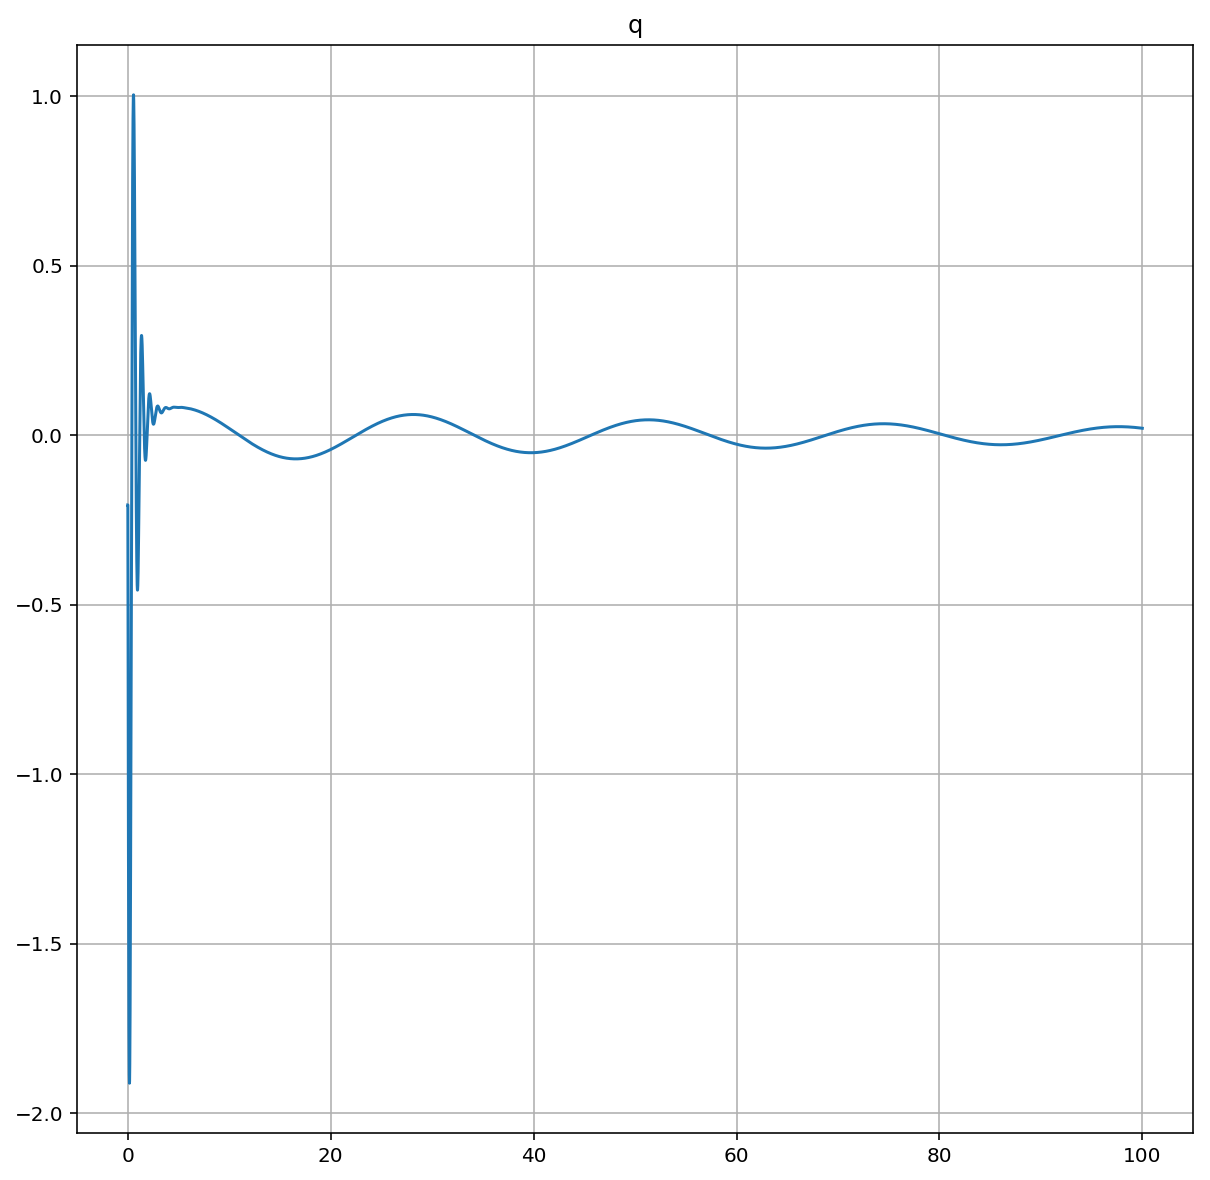

In [10]:
plt.plot(np.arange(0,total_time,dt),state_vector_history[:-1,-1])
plt.title('q')
plt.grid()
plt.show()